/home/sxa1953/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


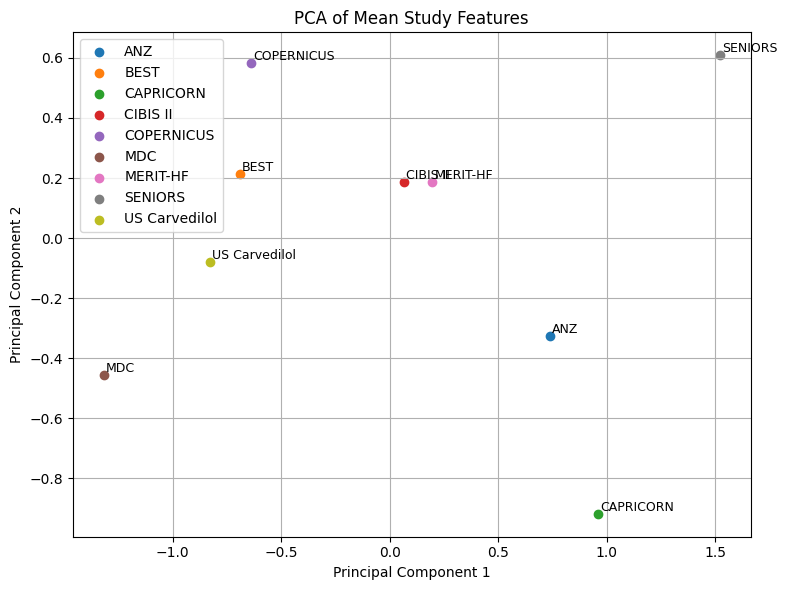

In [2]:
# PCA for RCTs numerical data only

import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load data
study_feature_df = pd.read_csv('cleaned_df_severe_outcome.csv', low_memory=False)

# Drop non-feature columns
features = study_feature_df.drop(columns=['ecgrhyt', 'study', 'upid', 'severe_outcome'])

# Define preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('qt', QuantileTransformer(output_distribution='normal', random_state=42), 
     ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']),
], remainder='passthrough')

# Apply preprocessing
X_processed = preprocessor.fit_transform(features)

# Add back study label
studies = study_feature_df['study'].values
processed_df = pd.DataFrame(X_processed)
processed_df['study'] = studies

# Compute mean feature vector per study
study_means = processed_df.groupby('study').mean()

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(study_means)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['study'] = study_means.index

# Plot the PCA result
plt.figure(figsize=(8, 6))
for _, row in pca_df.iterrows():
    plt.scatter(row['PC1'], row['PC2'], label=row['study'])
    plt.text(row['PC1'] + 0.01, row['PC2'] + 0.01, row['study'], fontsize=9)

plt.title('PCA of Mean Study Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
M07/severe_outcome/graphs/feature similarity

/home/sxa1953/.local/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


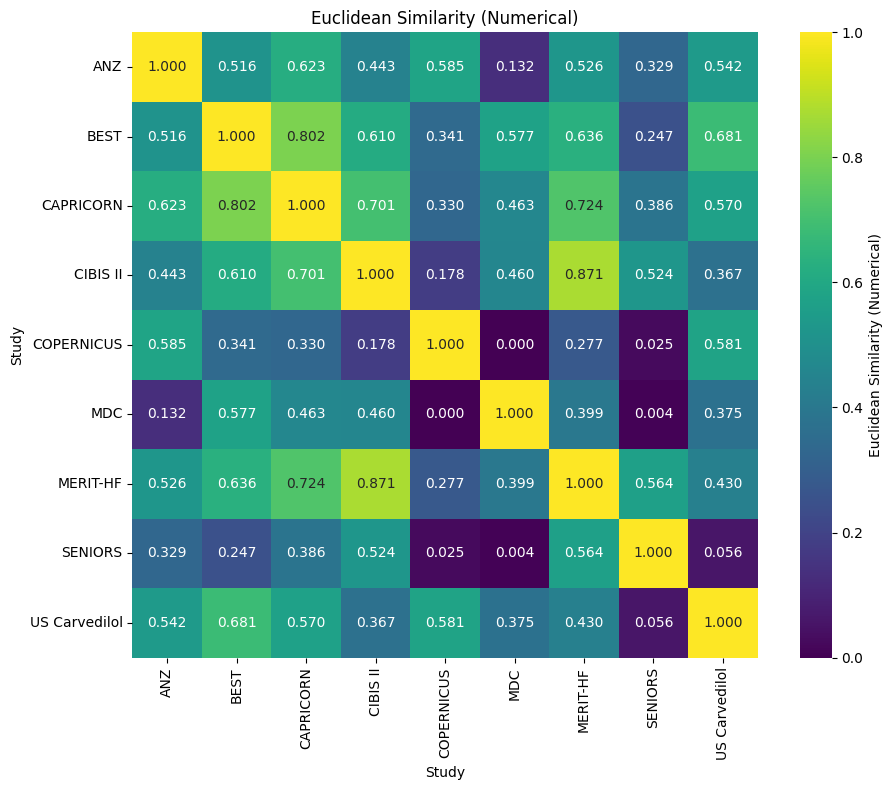

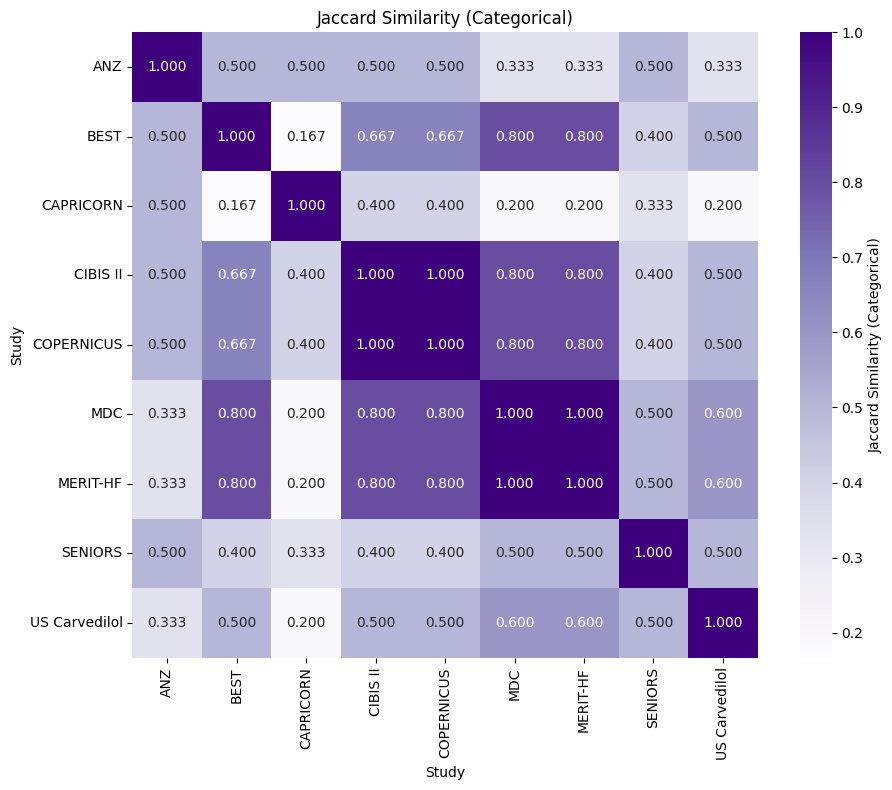

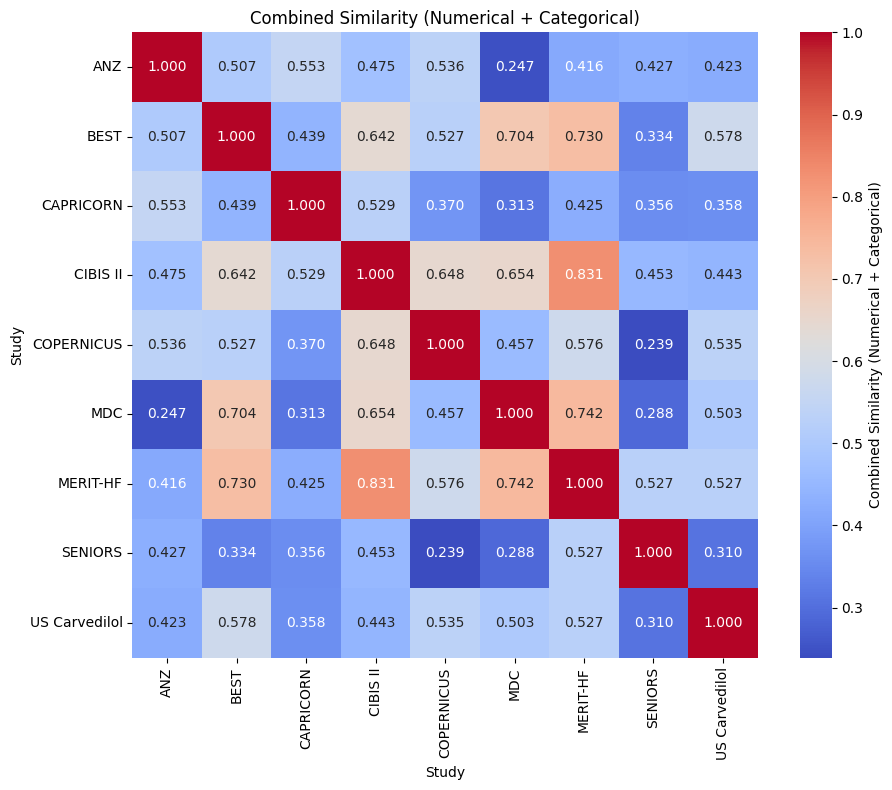

In [3]:
# Feauture similarities, num, cat, all

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv('cleaned_df_severe_outcome.csv', low_memory=False)

# Define feature sets
numerical_cols = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
categorical_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'gender', 'nyhac2', 'severe_outcome'] #add 'severe_outcome'?

# Extract study label and features
study_labels = df['study']
features = df[numerical_cols + categorical_cols].copy()

# Preprocess numerical features
preprocessor = ColumnTransformer(transformers=[
    ('qt', QuantileTransformer(output_distribution='normal', random_state=42), numerical_cols)
], remainder='passthrough')

X_processed = preprocessor.fit_transform(features)
feature_names = numerical_cols + categorical_cols
X_df = pd.DataFrame(X_processed, columns=feature_names)
X_df['study'] = study_labels

# --- Group by study ---
num_means = X_df.groupby('study')[numerical_cols].mean()
cat_means = X_df.groupby('study')[categorical_cols].mean()


# --- Similarity/Dissimilarity Matrices ---

# 1. Cosine Similarity (Numerical)
#cos_sim = cosine_similarity(num_means)
#cosine_df = pd.DataFrame(cos_sim, index=num_means.index, columns=num_means.index)

# 2. Euclidean Distance (Numerical), converted to similarity
euclidean_dist = cdist(df_num_grouped, df_num_grouped, metric='euclidean')
scaler = MinMaxScaler() # Normalize the full matrix (flatten + scale globally)

euclidean_dist_flat = euclidean_dist.flatten().reshape(-1, 1)
euclidean_dist_scaled = scaler.fit_transform(euclidean_dist_flat).reshape(euclidean_dist.shape)
euclidean_sim = 1 - euclidean_dist_scaled  # Convert to similarity
euclidean_df = pd.DataFrame(euclidean_sim, index=df_num_grouped.index, columns=df_num_grouped.index) #reate DataFrame


# 3. Jaccard Similarity (Categorical, 0/1 proportion)
cat_binary = (cat_means > 0.5).astype(int)
jaccard_dist = pairwise_distances(cat_binary.values, metric='jaccard')
jaccard_sim = 1 - jaccard_dist
jaccard_df = pd.DataFrame(jaccard_sim, index=cat_means.index, columns=cat_means.index)

# 4. Combined Weighted similarity (Categorical and Numerical)
n_num = len(numerical_cols)
n_cat = len(categorical_cols)
total = n_num + n_cat

combined_sim = (n_num / total) * euclidean_sim + (n_cat / total) * jaccard_sim
combined_df = pd.DataFrame(combined_sim, index=num_means.index, columns=num_means.index)


# --- Plots ---
def plot_heatmap(df, title, cmap, label='Study', filename='heatmap.png'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, fmt=".3f", cmap=cmap, square=True, cbar_kws={'label': title})
    plt.title(title)
    plt.xlabel(label)
    plt.ylabel(label)
    plt.tight_layout()
    plt.savefig(f"graphs/{filename}", dpi=300)
    plt.show()

# Call plots with unique filenames
plot_heatmap(euclidean_df, 'Euclidean Similarity (Numerical)', cmap='viridis', filename='euclidean_similarity.png')
plot_heatmap(jaccard_df, 'Jaccard Similarity (Categorical)', cmap='Purples', filename='jaccard_similarity.png')
plot_heatmap(combined_df, 'Combined Similarity (Numerical + Categorical)', cmap='coolwarm', filename='combined_similarity.png')
# plot_heatmap(cosine_df, 'Cosine Similarity (Numerical)', cmap='YlGnBu', filename='cosine_similarity.png')  # if used


In [10]:
ls

'1. cleaning_method.ipynb'                   feature_similarity.ipynb
'2. initial_modeling-severe_outcome.ipynb'   graphs/
'3. Best_model_severe_outcome.ipynb'         loop_loso.ipynb
'4. LR_XGBoost_combined.ipynb'              'results df'/
'5. SHAP.ipynb'                              study_distributions/
'6. Performance_Prediction.ipynb'            trial_error/
 cleaned_df_severe_outcome.csv              'X. plot for loso.ipynb'
 extracted_df_severe_outcome.csv            'X. scaler_loop.ipynb'


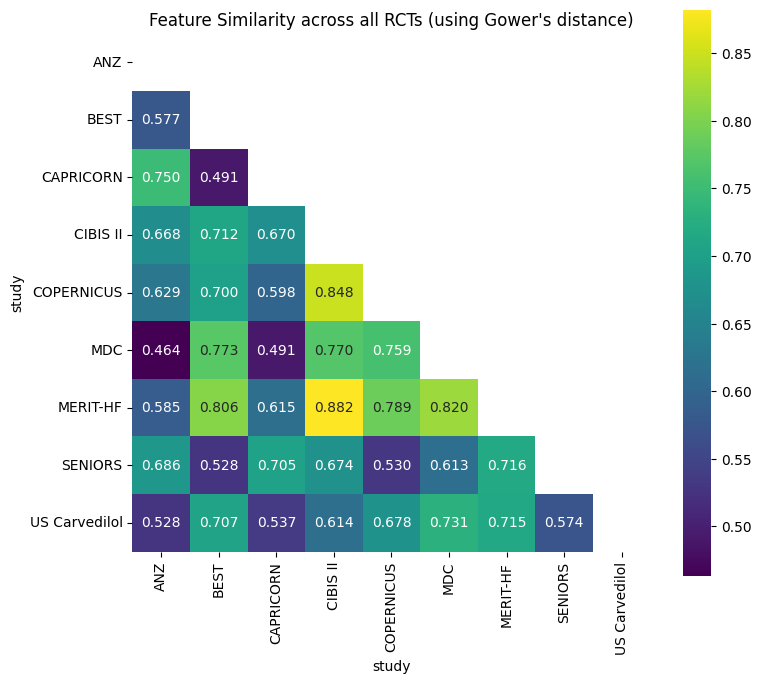

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gower

# Load data
df = pd.read_csv('cleaned_df_severe_outcome.csv', low_memory=False)

# Define feature sets
numerical_cols = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
categorical_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'gender', 'nyhac2', 'severe_outcome'] #add 'severe_outcome'?

# Group by study for numerical columns (mean)
df_num_grouped = df.groupby('study')[numerical_cols].mean()

# Group by study for categorical columns (mode - get first mode only)
df_cat_grouped = df.groupby('study')[categorical_cols].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])

# Combine grouped numerical and categorical features
df_grouped = pd.concat([df_num_grouped, df_cat_grouped], axis=1)

# Ensure categorical dtype
for col in categorical_cols:
    df_grouped[col] = df_grouped[col].astype('str')

# Define weights proportional to feature counts
num_cat = len(categorical_cols)
num_num = len(numerical_cols)

weight_cat_total = num_cat / (num_cat + num_num)
weight_num_total = num_num / (num_cat + num_num)

weights = []
for col in df_grouped.columns:
    if col in categorical_cols:
        weights.append(weight_cat_total / num_cat)
    else:
        weights.append(weight_num_total / num_num)

# Mask for categorical features
cat_mask = [col in categorical_cols for col in df_grouped.columns]

weights = np.array(weights)

# Compute Gower similarity with weights and cat mask
gower_dist = gower.gower_matrix(df_grouped, weight=weights, cat_features=cat_mask)
gower_sim = 1 - gower_dist

# Create similarity DataFrame
gower_df = pd.DataFrame(gower_sim, index=df_grouped.index, columns=df_grouped.index)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(gower_df, dtype=bool))

# Plot heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(gower_df, 
            mask=mask, # take this out if you want complete heatmap.
            cmap='viridis', 
            annot=True, 
            fmt=".3f", 
            square=True, 
            xticklabels=True, 
            yticklabels=True, 
            cbar_kws={"shrink": 0.8})
plt.title("Feature Similarity across all RCTs (using Gower's distance)")
plt.tight_layout()
plt.savefig("graphs/feature similarity/gower_similarity_heatmap.png", dpi=300)  # Save at 300 DPI
plt.show()

In [2]:
gower_df

study,ANZ,BEST,CAPRICORN,CIBIS II,COPERNICUS,MDC,MERIT-HF,SENIORS,US Carvedilol
study,,,,,,,,,
ANZ,1.000000,0.576696,0.749501,0.668314,0.629456,0.463698,0.585022,0.685951,0.528103
BEST,0.576696,1.000000,0.490784,0.711569,0.699694,0.772633,0.805835,0.528370,0.707220
CAPRICORN,0.749501,0.490784,1.000000,0.669721,0.598246,0.490965,0.614522,0.704810,0.536529
CIBIS II,0.668314,0.711569,0.669721,1.000000,0.847840,0.770458,0.882131,0.673943,0.614457
COPERNICUS,0.629456,0.699694,0.598246,0.847840,1.000000,0.758632,0.788513,0.529940,0.677733
MDC,0.463698,0.772633,0.490965,0.770458,0.758632,1.000000,0.819916,0.612733,0.731179
MERIT-HF,0.585022,0.805835,0.614522,0.882131,0.788513,0.819916,1.000000,0.715936,0.715321
SENIORS,0.685951,0.528370,0.704810,0.673943,0.529940,0.612733,0.715936,1.000000,0.574115
US Carvedilol,0.528103,0.707220,0.536529,0.614457,0.677733,0.731179,0.715321,0.574115,1.000000


In [3]:
weight_num_total

0.42857142857142855

In [4]:
weight_cat_total

0.5714285714285714

/home/sxa1953/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


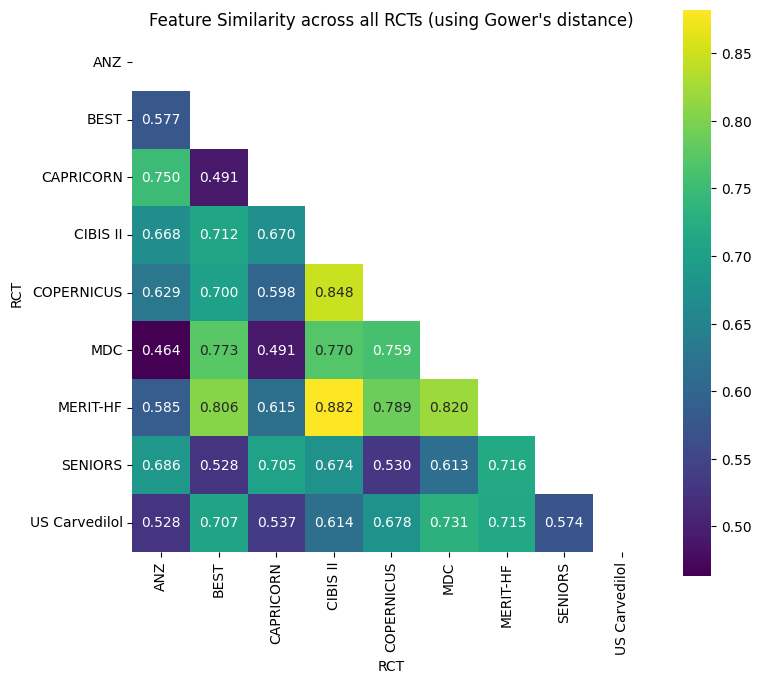

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gower

# Load data
df = pd.read_csv('cleaned_df_severe_outcome.csv', low_memory=False)

# Rename 'study' column to 'RCT'
df = df.rename(columns={'study': 'RCT'})

# Define feature sets
numerical_cols = ['age', 'bmi', 'hr', 'sbp', 'lvef', 'creat']
categorical_cols = ['mi', 'acearb', 'diur_any', 'anticoag', 'digoxin', 'gender', 'nyhac2', 'severe_outcome']

# Group by RCT for numerical columns (mean)
df_num_grouped = df.groupby('RCT')[numerical_cols].mean()

# Group by RCT for categorical columns (mode - get first mode only)
df_cat_grouped = df.groupby('RCT')[categorical_cols].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])

# Combine grouped numerical and categorical features
df_grouped = pd.concat([df_num_grouped, df_cat_grouped], axis=1)

# Ensure categorical dtype
for col in categorical_cols:
    df_grouped[col] = df_grouped[col].astype('str')

# Define weights proportional to feature counts
num_cat = len(categorical_cols)
num_num = len(numerical_cols)

weight_cat_total = num_cat / (num_cat + num_num)
weight_num_total = num_num / (num_cat + num_num)

weights = []
for col in df_grouped.columns:
    if col in categorical_cols:
        weights.append(weight_cat_total / num_cat)
    else:
        weights.append(weight_num_total / num_num)

# Mask for categorical features
cat_mask = [col in categorical_cols for col in df_grouped.columns]
weights = np.array(weights)

# Set index name to 'RCT'
df_grouped.index.name = 'RCT'

# Compute Gower similarity with weights and cat mask
gower_dist = gower.gower_matrix(df_grouped, weight=weights, cat_features=cat_mask)
gower_sim = 1 - gower_dist

# Create similarity DataFrame
gower_df = pd.DataFrame(gower_sim, index=df_grouped.index, columns=df_grouped.index)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(gower_df, dtype=bool))

# Plot heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(gower_df, 
            mask=mask, 
            cmap='viridis', 
            annot=True, 
            fmt=".3f", 
            square=True, 
            xticklabels=True, 
            yticklabels=True, 
            cbar_kws={"shrink": 0.8})
plt.title("Feature Similarity across all RCTs (using Gower's distance)")
plt.xlabel("RCT")
plt.ylabel("RCT")
plt.tight_layout()
plt.savefig("graphs/feature similarity/gower_similarity_heatmap.png", dpi=300)
plt.show()
